In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import ndimage

In [2]:
from utils import cluster
from utils import plot_utils
from utils.config import(
    data_path,
    test_path,
    csv_folder,
    STDEV_THRESHOLD,
    AREA_THRESHOLD,
    input_for_clusters,
    output_from_clusters,
    output_from_clusters_table,
    anomaly_dim,
    latitude_dim_name,
    mask_dim,
    area_dim,
    label_dim,
    time_dim,
    label_filtered_dim
)

In [3]:
new_cmap_viridis = plot_utils.set_white_color(plt.cm.viridis)
new_cmap_set1 =  plot_utils.set_white_color(plt.cm.Set1)

In [4]:
#Open input file
ds = xr.open_dataset("{}{}".format(data_path,input_for_clusters))

In [5]:
ds

<xarray.Dataset> Size: 61MB
Dimensions:         (latitude: 281, longitude: 441, time: 124)
Coordinates:
  * latitude        (latitude) float32 1kB 90.0 89.75 89.5 ... 20.5 20.25 20.0
  * longitude       (longitude) float32 2kB -150.0 -149.8 ... -40.25 -40.0
  * time            (time) datetime64[ns] 992B 1970-02-06 ... 2000-02-09
Data variables:
    anomaly_scaled  (time, latitude, longitude) float32 61MB ...

## mask by stdev threshold

In [6]:
ds[mask_dim] = ds[anomaly_dim] <= STDEV_THRESHOLD

In [12]:
t_example = '1985-02-07'

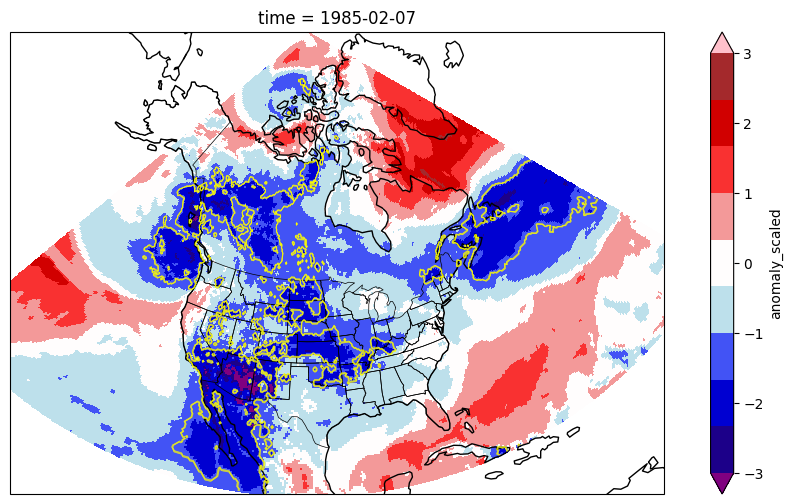

In [13]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
plot_utils.da_plot_zero_centered(ds.sel(time=t_example)['anomaly_scaled'])
ds.sel(time=t_example)[mask_dim].plot.contour(transform=ccrs.PlateCarree(),colors='yellow',linewidths=0.3)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

Yellow contours highlighting clusters where scaled anomalies < -1.5C

## Label clusters and filter by area size

In [14]:
#Calculate and broadcast area of each grid cell
grid_areas = cluster.area_weights(ds[mask_dim],
                                  latitude_dim_name=latitude_dim_name)
ds[area_dim] = grid_areas.broadcast_like(ds.isel(time=1))

In [15]:
#Label clusters and filter by area size
ds=ds.groupby(time_dim).map(cluster.label_and_filter,
                             mask_dim=mask_dim,
                             area_dim=area_dim,
                            label_dim=label_dim,
                            label_filtered_dim=label_filtered_dim,
                             AREA_THRESHOLD=AREA_THRESHOLD)

In [16]:
#Get information about filtered clusters
list_df = list()
for t in ds.where(ds.has_clusters,drop=True).time.values:
    data_set = ds.sel(time=t)
    info_temp = cluster.get_cluster_info(data_set,
                                            label_dim=label_dim,
                                            label_filtered_dim=label_filtered_dim,
                                            anomaly_dim=anomaly_dim,
                                            area_dim=area_dim)
    list_df.append(info_temp)

cluster_info_df = pd.concat(list_df,axis=0)

## Example: all labeled clusters

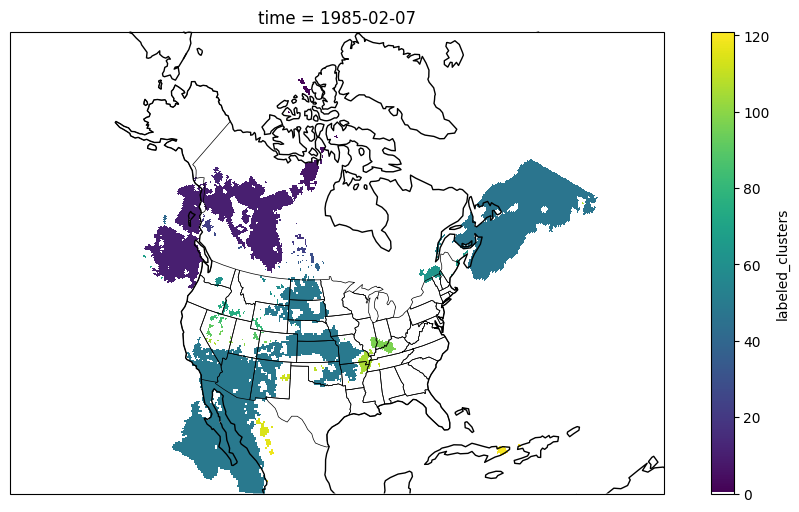

In [17]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time=t_example)[label_dim].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Example: filtered labeled clusters

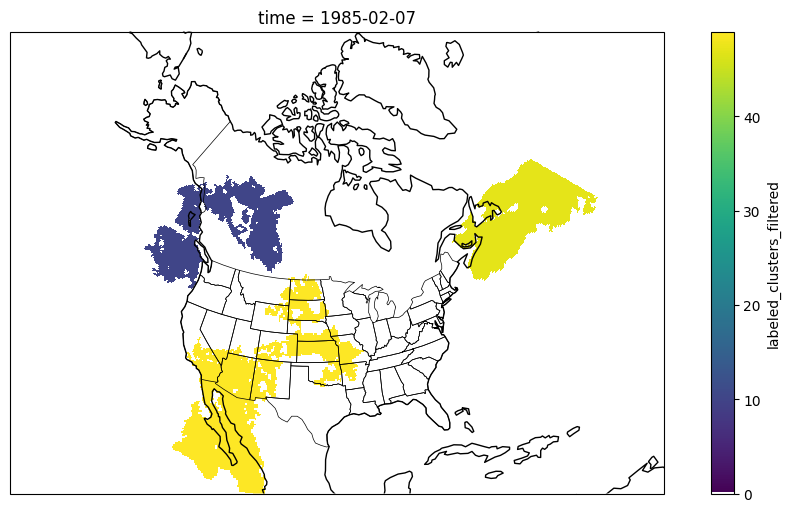

In [19]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds.sel(time=t_example)[label_filtered_dim].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Deforming clusters using binary masks

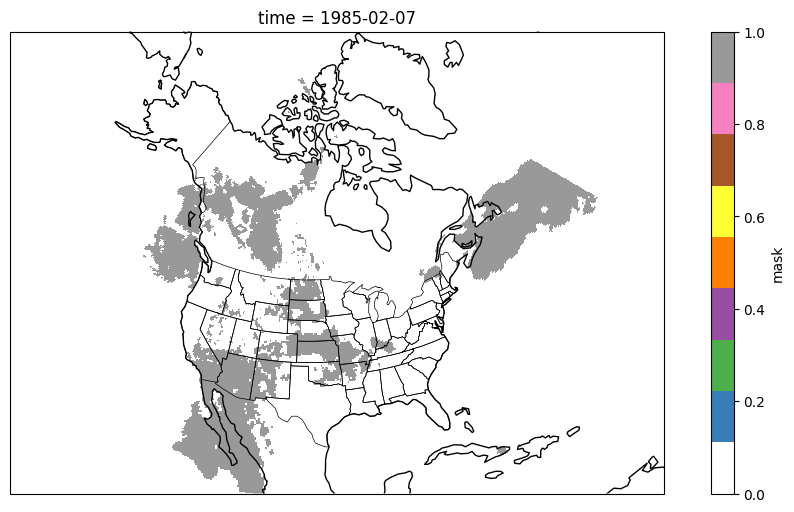

In [20]:
#Original
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
ds[mask_dim].sel(time=t_example).plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

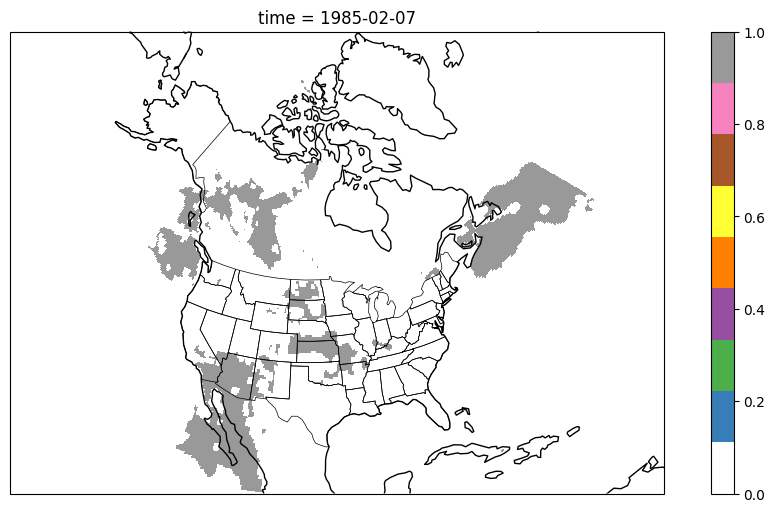

In [21]:
#Erosion
a=cluster.apply_binary_morph(ds[mask_dim].sel(time=t_example),method='erosion',s=np.ones((3,3)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

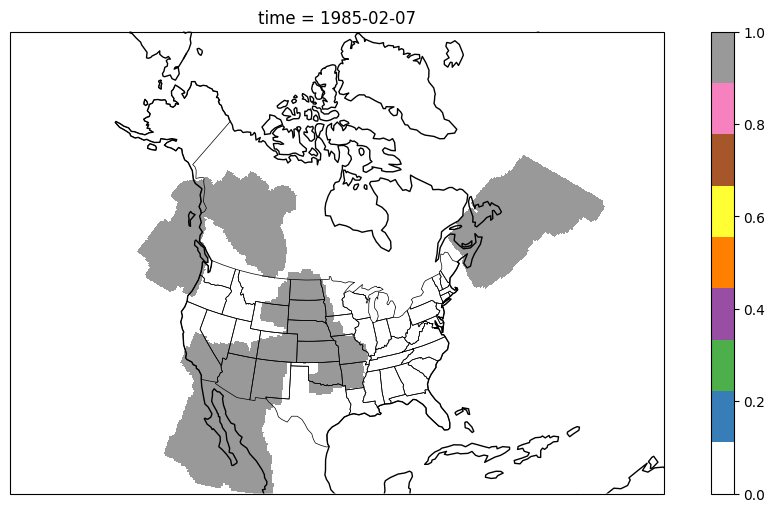

In [22]:
#Sequence of deformations
a = ds[label_filtered_dim].sel(time=t_example)
a=cluster.apply_binary_morph(a,method='closing',s=np.ones((3,3)))
a=cluster.apply_binary_morph(a,method='erosion',s=np.ones((2,2)))
a=cluster.apply_binary_morph(a,method='dilation',s=np.ones((9,9)))
a=cluster.apply_binary_morph(a,method='fill_holes',s=np.ones((7,7)))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=-100))
a.plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()

## Area coverage

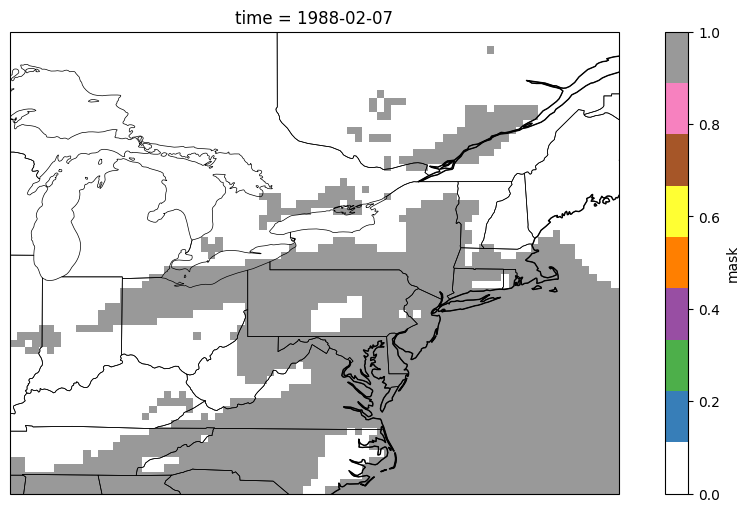

In [24]:
data_set = ds.sel(time='1988-02-07')
data_set = data_set.sel(latitude=slice(50, 34.5), longitude=slice(-88.5, -68))
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set[mask_dim].plot(cmap=new_cmap_set1)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

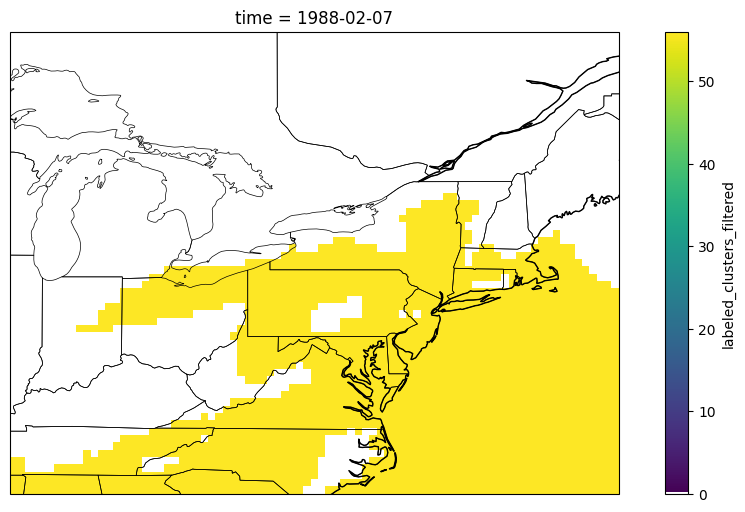

In [25]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set[label_filtered_dim].plot(cmap=new_cmap_viridis)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

total area under CAO 

In [26]:
#Total domain area
total_area = data_set['areas'] .sum()
data_set['areas_weight'] = data_set['areas']/total_area

In [27]:
#data_set.groupby('labeled_clusters_filtered').sum()['areas']
clusters_label = np.unique(data_set['labeled_clusters_filtered'])
clusters_label = clusters_label[clusters_label>0]
np.sum(ndimage.sum_labels(data_set['areas'],data_set["labeled_clusters"],clusters_label))

np.float64(1202119.9488731422)

total area where scaled anomaly is less than -1.5C

In [28]:
((data_set['mask'].astype(int) * data_set['areas']).sum()).values

array(1294866.48246359)

## Gaussian filter

In [30]:
data_set["G"] = cluster.gaussian_filter(data_set=data_set,center_lon = -75.6,center_lat = 42.9,b=0.18)
data_set['G']  = data_set['G']/np.max(data_set['G'])

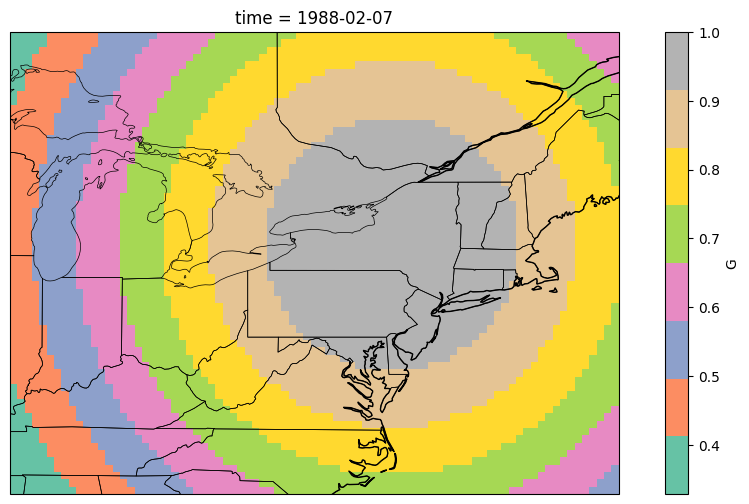

In [31]:
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['G'].plot(cmap='Set2')
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
plt.show()

## Area coverage using different filters

In [32]:
#Coverage by number of points
total_points = np.size(data_set.latitude) * np.size(data_set.longitude)
(np.sum(data_set['mask'])/total_points).values

array(0.41288965)

In [33]:
#Coverage weighted by area
total_area = np.sum(data_set['areas'])
(np.sum((data_set['areas']*data_set['mask']))/total_area).values

array(0.43427474)

In [34]:
#Coverage weighted by gaussian
total_gaussian = np.sum(data_set.G)
(np.sum((data_set['G']*data_set['mask']))/total_gaussian).values

array(0.43952014)

## Plot cluster center of mass

In [35]:
t = '1985-02-07'
data_set = ds.sel(time=t)
temp_info = cluster_info_df[cluster_info_df.time==t]
temp_info

,label,area,time,cm_lat,cm_lon,mean,stdev,median,min_value,min_lat,min_lon
0,10,2.051900e+06,1985-02-07,141,106,-1.810760,0.258673,-1.737066,-3.168368,145,76
1,47,1.971783e+06,1985-02-07,182,395,-1.852463,0.226216,-1.828007,-2.637676,169,390
2,49,2.831348e+06,1985-02-07,223,170,-1.929531,0.400737,-1.829411,-4.023245,228,163


In [36]:
temp_info.cm_lon

0    106
1    395
2    170
Name: cm_lon, dtype: int64

In [37]:
lons = data_set.longitude.values[temp_info.cm_lon]
lats = data_set.latitude.values[temp_info.cm_lat]

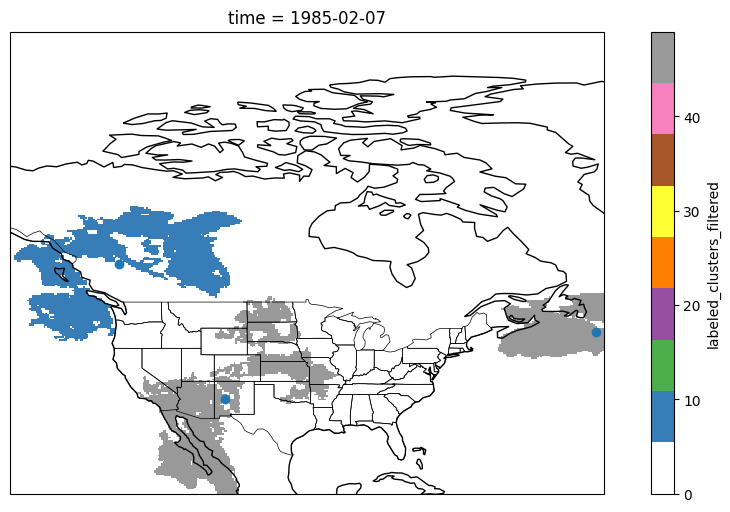

In [38]:
'''''
Testing center of mass coordinates
'''''
plt.figure(figsize=(12, 6))
axes = plt.axes(projection=ccrs.PlateCarree())
data_set['labeled_clusters_filtered'].plot(transform=ccrs.PlateCarree(),cmap=new_cmap_set1)
plt.scatter(lons,lats)
axes.coastlines()
axes.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
axes.set_extent((-140, -50, 20, 90),ccrs.PlateCarree())
plt.show()